# Training an SNN using Neuroevolution!

Featuring Regularization to try reducing silent neurons!!!

In [33]:
import spyx
import spyx.nn as snn

# JAX imports
import os
import jax
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".75"
from jax import numpy as jnp
import jmp
import numpy as np

from tqdm import tqdm

# implement our SNN in DeepMind's Haiku
import haiku as hk

# optimize the parameters using evosax
import evosax
#from evosax.strategies import LM_MA_ES as LMMAES
from evosax.strategies import CR_FM_NES as CRFMNES


from evosax import FitnessShaper

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# rendering tools
import matplotlib.pyplot as plt
%matplotlib notebook

In [34]:
policy = jmp.get_policy('half')

hk.mixed_precision.set_policy(hk.Linear, policy)
hk.mixed_precision.set_policy(snn.RLIF, policy)
hk.mixed_precision.set_policy(snn.LI, policy)

## Data Loading

In [35]:
shd_dl = spyx.data.SHD_loader(128, 100, 350)

In [36]:
shd_dl.train_step().obs.shape

(128, 100, 350)

## SNN

In [37]:
def shd_snn(x):
    core = hk.DeepRNN([
        hk.Linear(128, with_bias=False),
        snn.RLIF((128,)),
        spyx.activation.ActivityRegularization(),
        hk.Linear(128, with_bias=False),
        snn.RLIF((128,)),
        spyx.activation.ActivityRegularization(),
        hk.Linear(20, with_bias=False),
        snn.LI((20,))
    ])
    # static unroll for maximum performance
    spikes, V = hk.dynamic_unroll(core, x.astype(jnp.float32), core.initial_state(x.shape[0]), time_major=False, unroll=10)
    return spikes, V

In [38]:
key = jax.random.PRNGKey(0)
SNN = hk.without_apply_rng(hk.transform_with_state(shd_snn))
params, reg_init = SNN.init(rng=key, x=shd_dl.train_step().obs)

## Evolution

In [41]:
def evolution(SNN, params, dl, epochs=60, test_every=1, key=0):

    rng = jax.random.PRNGKey(key)
    param_reshaper = evosax.ParameterReshaper(params)
        

    # Instantiate jittable fitness shaper (e.g. for Open ES)
    fit_shaper = FitnessShaper(centered_rank=False,
                           z_score=False,
                           w_decay=0.01,
                           maximize=True)

    # Shape the evaluated fitness scores
    
    strategy = CRFMNES(popsize=512,
                  #elite_ratio=0.25,
                  num_dims=param_reshaper.total_params,
                )

    es_params = strategy.default_params
    es_params = es_params.replace()

    state = strategy.initialize(rng)

    @jax.jit
    def net_eval(individual, events, targets):
        readout, spike_counts = SNN.apply(individual, reg_init, events)
        traces, V = readout
        acc, _ = spyx.loss.integral_accuracy(traces, targets)
        return acc
    
    @jax.jit
    def net_test(individual, events, targets):
        readout, spike_counts = SNN.apply(individual, reg_init, events)
        traces, V = readout
        acc, pred = spyx.loss.integral_accuracy(traces, targets)
        return acc
    
    sim_fn = jax.vmap(net_eval, (0, None, None))
    test_fn = jax.vmap(net_test, (0, None, None))
    
    @jax.jit
    def step(rng, state, events, targets):
        rng, rng_ask = jax.random.split(rng, 2)
        # ASK
        pop, state = strategy.ask(rng_ask, state)
        population_params = param_reshaper.reshape(pop.astype(jnp.float32))
        # EVAL
        fit = sim_fn(population_params, events, targets) 
        # TELL
        fit_shaped = fit_shaper.apply(pop, fit) 
        state = strategy.tell(pop, fit_shaped, state)        
        
        return rng, state, fit
    
    
    for gen in range(epochs):
        dl.train_reset()
        pbar = tqdm([*range(dl.train_len//dl.batch_size)])
        pbar.set_description("Epoch #{}".format(gen))
        for _ in pbar:
            events, targets = dl.train_step() # non-jittable...
    
            rng, state, acc = step(rng, state, events, targets)
            
            pbar.set_postfix(Fitness=jnp.max(acc))
        
        elite = param_reshaper.reshape(jnp.array([state.best_member]))
        if gen % test_every == test_every-1:
            dl.val_reset()
            accs = []
            
            pbar = tqdm([*range(dl.val_len//dl.batch_size)])
            pbar.set_description("Validate")
            for _ in pbar:
                events, targets = dl.val_step()
                
                acc = test_fn(elite, events, targets)
                
                accs.append(acc)
                
                pbar.set_postfix(Fitness=np.mean(accs))
        
    return jax.tree_util.tree_map(lambda x: x[0], elite)

In [42]:
elite_params = evolution(SNN, params, shd_dl) # SNES

ParameterReshaper: 64256 parameters detected for optimization.


Epoch #50: 100%|█████████████| 56/56 [00:26<00:00,  2.13it/s, Fitness=0.4296875]


Validate: 100%|████████████████████| 7/7 [00:03<00:00,  2.25it/s, Fitness=0.501]


In [43]:
def plot_readout(data, tgt_label):
    plt.imshow(data.T, aspect="auto")
    plt.title("Readout Activations")
    plt.xlabel("Time")
    plt.ylabel("Class")
    plt.title("Class Label: {}".format(tgt_label))
    plt.colorbar()
    plt.yticks(range(data.shape[-1]))
    plt.show()
    

In [44]:
shd_dl.train_reset()
sample = shd_dl.train_step()

In [45]:
sample.obs[0].shape

(100, 350)

In [61]:
import pickle

with open("./elite_shd_44_9_2x128RLIF.pkl", "wb") as f:
    pickle.dump(elite_params, f)

In [46]:
readout, spk_cts = SNN.apply(elite_params, reg_init, sample.obs)

In [47]:
sum(spk_cts["ActReg"]["spike_count"][0])

Array(2596., dtype=float16)

In [48]:
s, v = readout

In [49]:
s

Array([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 3.1406e+01,  2.1855e+00,  3.3312e+01, ..., -3.2288e-02,
         -2.4391e+01, -9.2031e+00],
        ...,
        [-6.7312e+01, -3.7938e+01,  2.4500e+02, ..., -1.0094e+02,
         -2.9453e+01, -4.9094e+01],
        [-6.7312e+01, -3.9812e+01,  2.4525e+02, ..., -1.0381e+02,
         -3.0922e+01, -4.5906e+01],
        [-7.2000e+01, -3.8281e+01,  2.4975e+02, ..., -1.0481e+02,
         -2.9266e+01, -4.8750e+01]],

       [[ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 7.1094e-01, -1.2320e+01,  2.4922e+01, ...,  1.8781e+01,
         -1.1492e+01, -5.5625e+00],
        ...,
        [-8.9312e+01, -5.5281e+01,  2.9450e+02, ..., -

In [50]:
jnp.sum(s, axis=0) # the network is almost entirely silent!!!!!!

Array([[     0. ,      0. ,      0. , ...,      0. ,      0. ,      0. ],
       [     0. ,      0. ,      0. , ...,      0. ,      0. ,      0. ],
       [  1729. ,   -700.5,   1801. , ...,   2238. ,  -1197. ,  -1019. ],
       ...,
       [-13248. ,  -4688. ,  18320. , ..., -14736. ,   8064. , -11968. ],
       [-13328. ,  -4796. ,  18496. , ..., -15008. ,   8056. , -12016. ],
       [-13400. ,  -4812. ,  18624. , ..., -15304. ,   7904. , -12048. ]],      dtype=float16)

In [51]:
sample.labels

Array([10,  4,  6,  9,  3, 15, 10, 13, 10,  8, 17, 18,  0, 18, 12,  1,  4,
        9, 18,  5, 19,  0,  4,  2,  1,  1, 11,  0,  2, 17, 16, 13, 12,  1,
        6, 15, 18,  3, 15, 16, 13, 16,  7, 17,  8, 14,  2, 18, 10, 18,  2,
        3, 12,  4,  6, 16, 19, 13, 11,  5,  5,  6, 14, 13,  1, 10, 12, 16,
       14,  0, 14,  4,  9, 19, 10,  5, 13,  6,  3, 14,  0,  9,  9, 17,  6,
        3,  7,  4,  1, 12, 16,  4,  8,  5, 10, 15, 15, 19, 13, 17,  4, 13,
       15, 19,  0,  6,  1, 14,  1,  2,  9,  1, 15, 14,  9, 18, 15,  4,  9,
       14, 13, 10, 16,  8, 19, 10, 14, 12], dtype=int32)

<IPython.core.display.Javascript object>


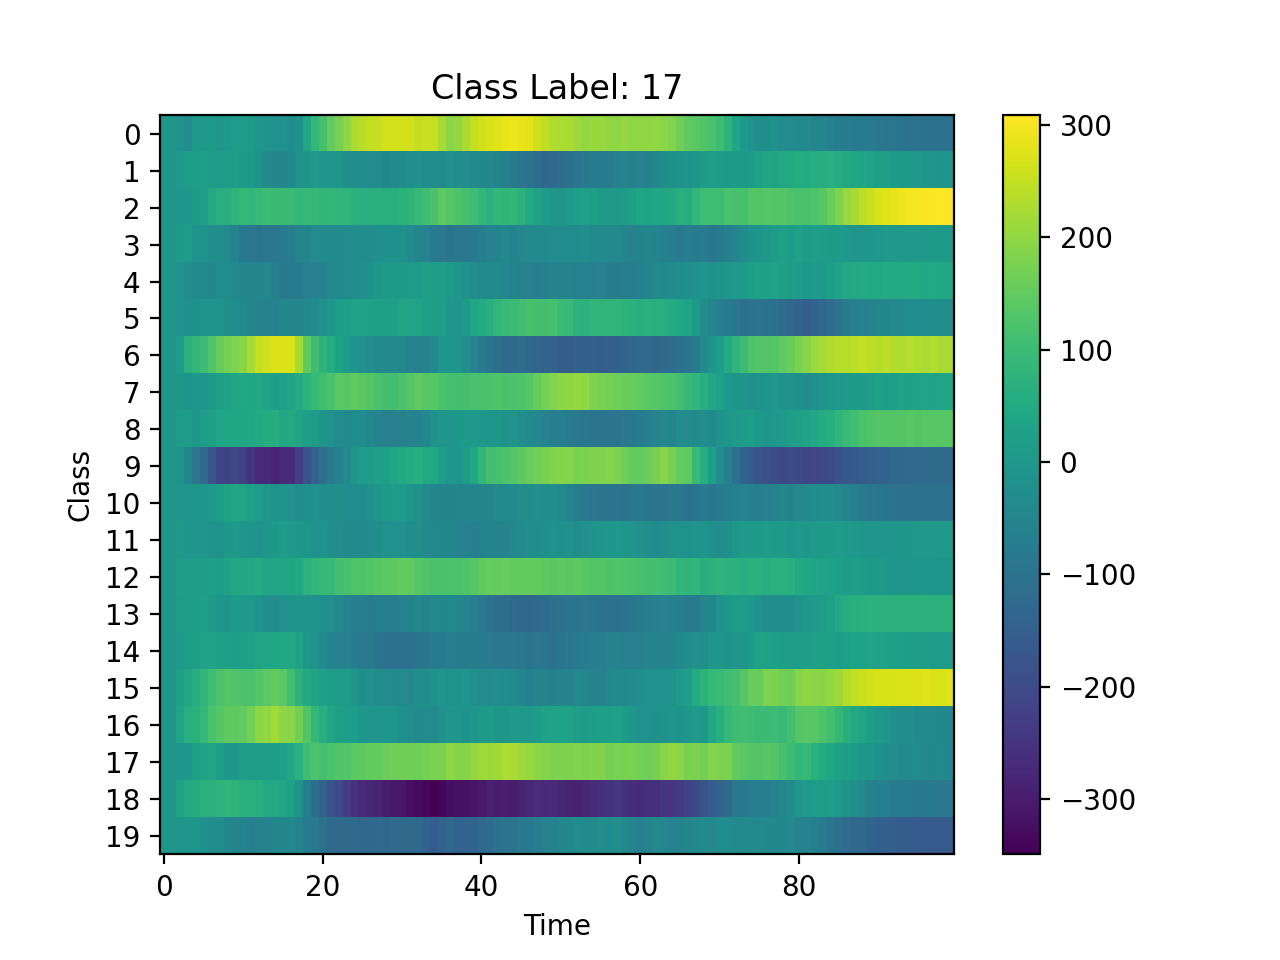

In [52]:
plot_readout(s[10], sample.labels[10])

<IPython.core.display.Javascript object>


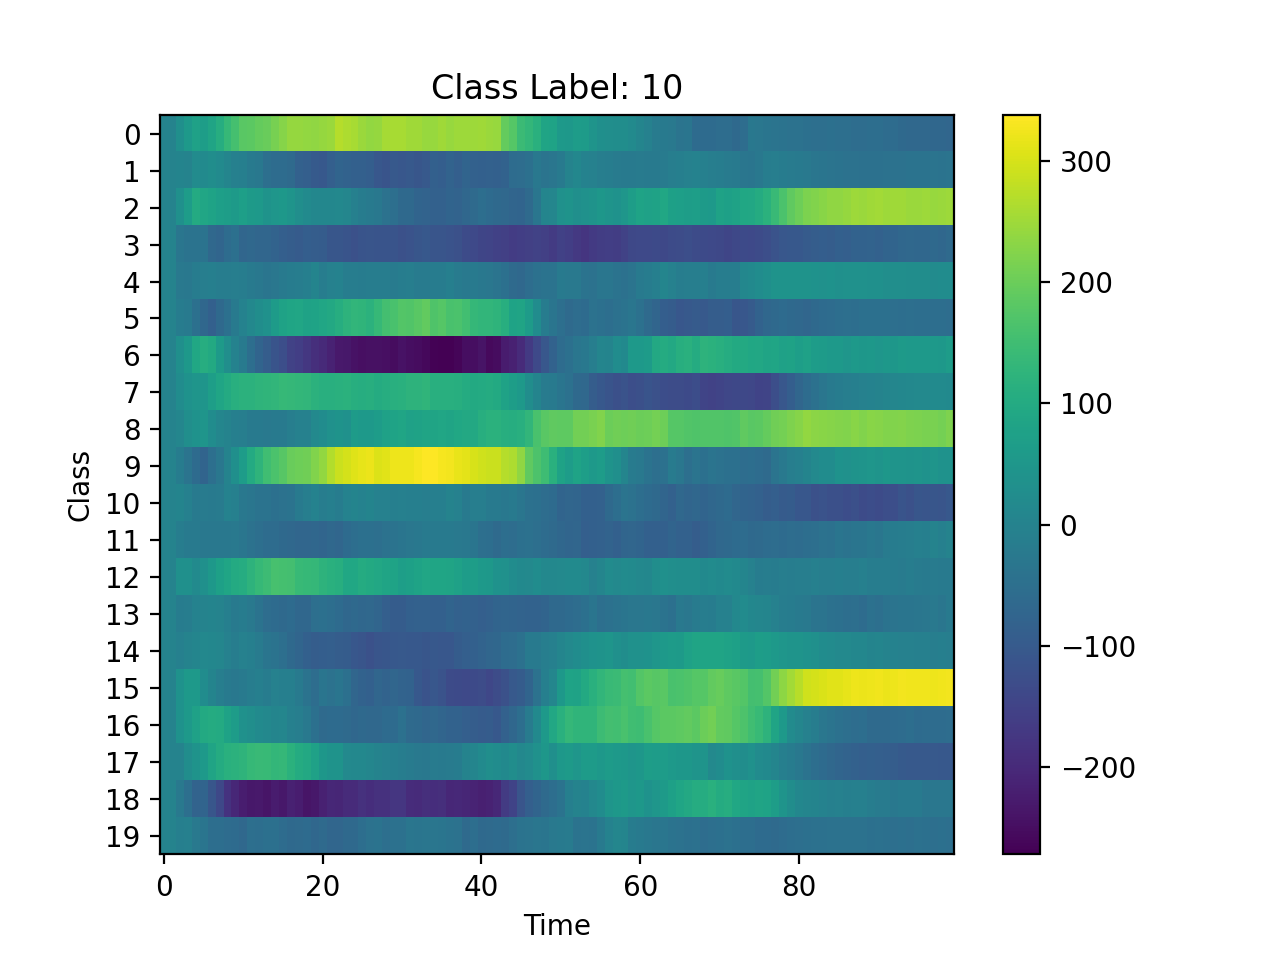

In [53]:
plot_readout(s[0], sample.labels[0])

In [54]:
def test(SNN, in_params, dl):

    @jax.jit
    def net_test(individual, events, targets):
        readout, spike_counts = SNN.apply(individual, reg_init, events)
        traces, V = readout
        acc, pred = spyx.loss.integral_accuracy(traces, targets)
        return acc, pred
    
    dl.test_reset()
    accs = []
    preds = []
    tgts = []
    
    pbar = tqdm([*range(dl.test_len//dl.batch_size)])
    pbar.set_description("Validating")
    for _ in pbar:
        events, targets = dl.test_step()
        
        acc, pred = net_test(in_params, events, targets)
        
        accs.append(acc)
        preds.append(pred)
        tgts.append(targets)
        
        pbar.set_postfix(Accuracy=np.mean(accs))
    
    return accs, preds, tgts

In [55]:
acc, preds, tgts = test(SNN, elite_params, shd_dl)

Validating: 100%|███████████████| 17/17 [00:09<00:00,  1.76it/s, Accuracy=0.449]


In [56]:
P, T = np.array(preds).flatten(), np.array(tgts).flatten()

<IPython.core.display.Javascript object>


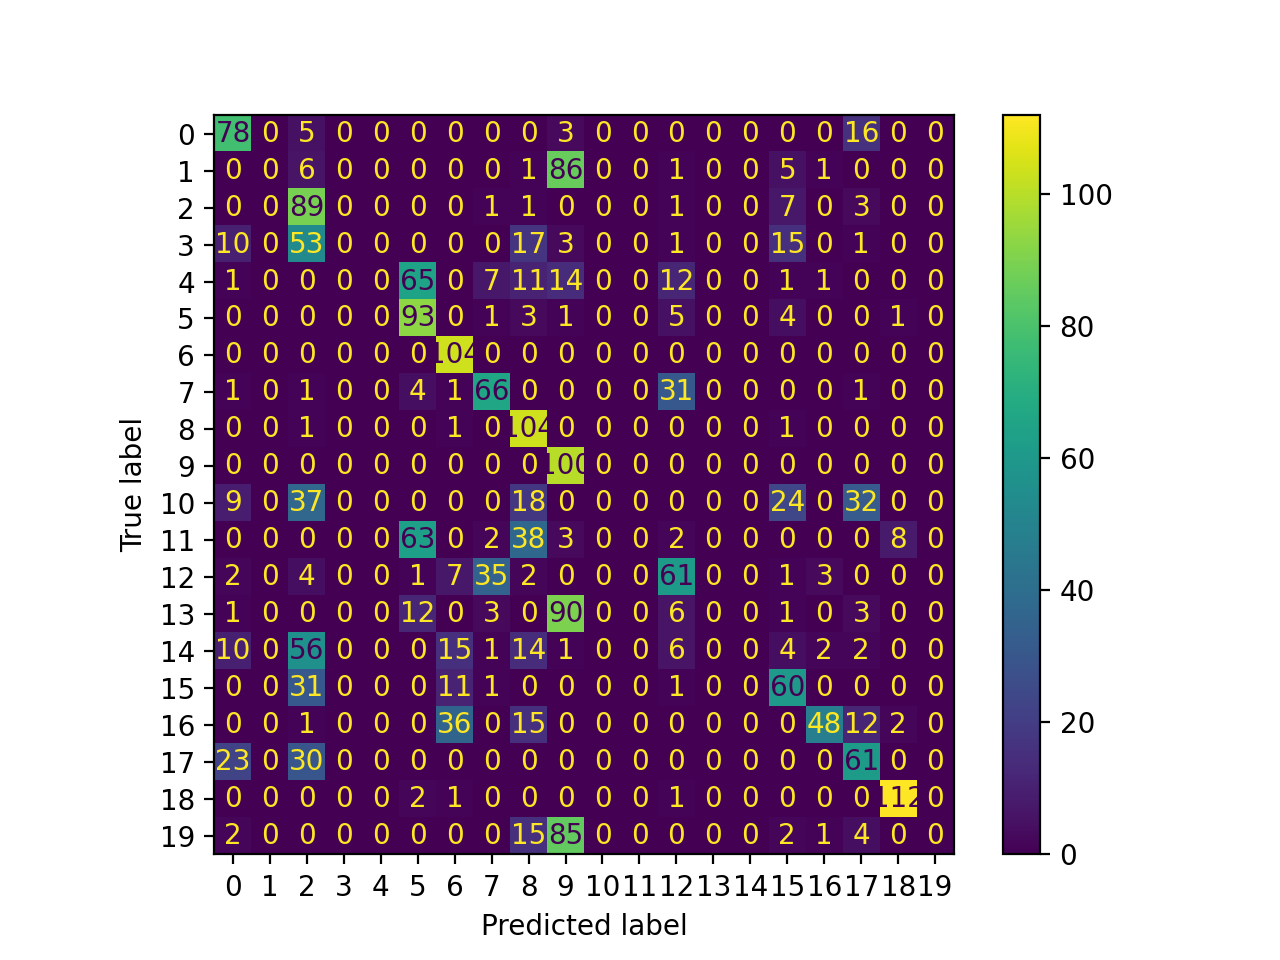

In [57]:
cm = confusion_matrix(T, P)
ConfusionMatrixDisplay(cm).plot()
plt.show()

<IPython.core.display.Javascript object>


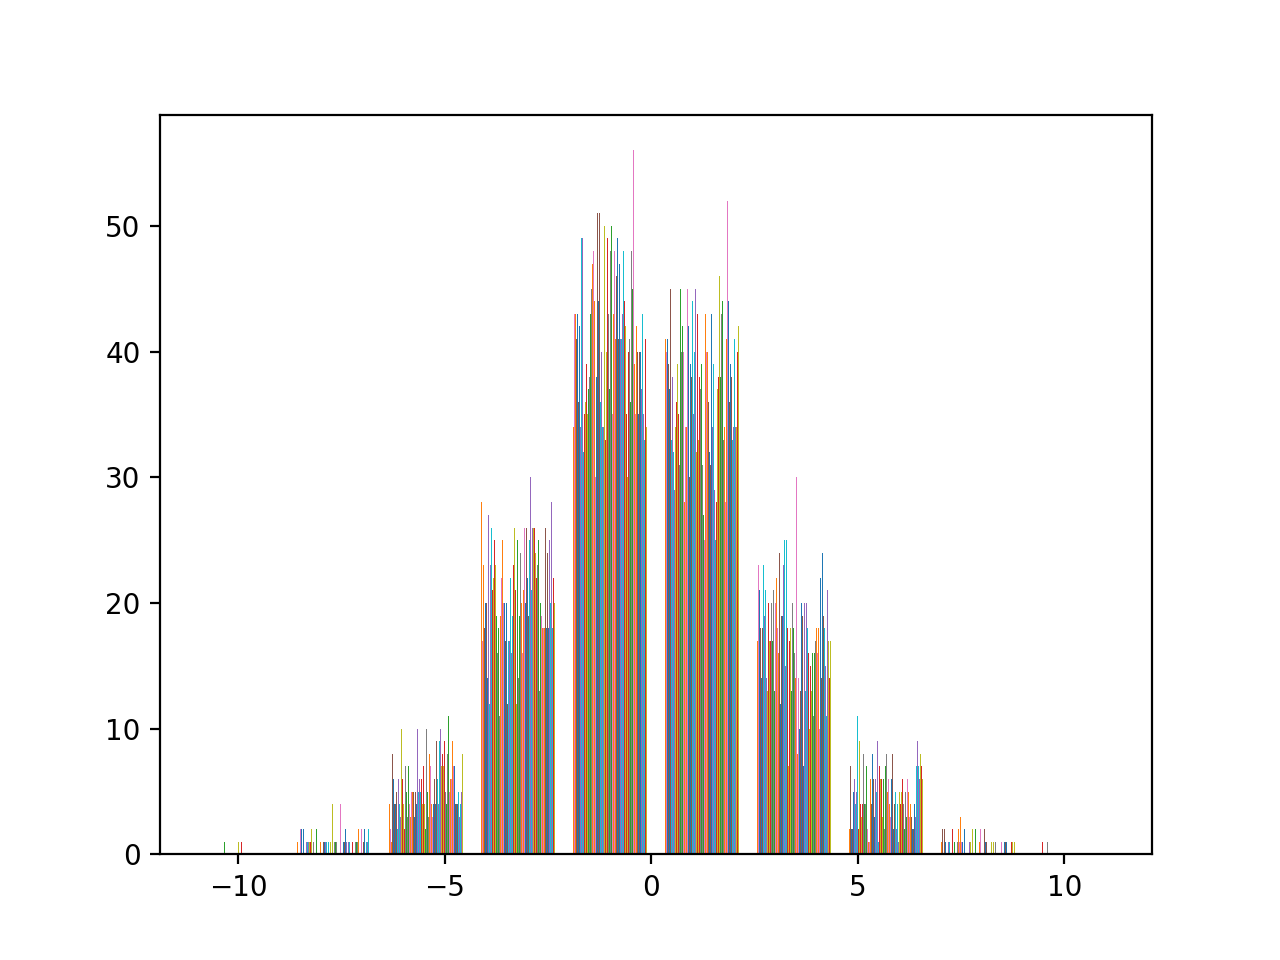

In [58]:
plt.hist(elite_params["linear"]["w"]) # input weights hidden layer 1
plt.show()

<IPython.core.display.Javascript object>


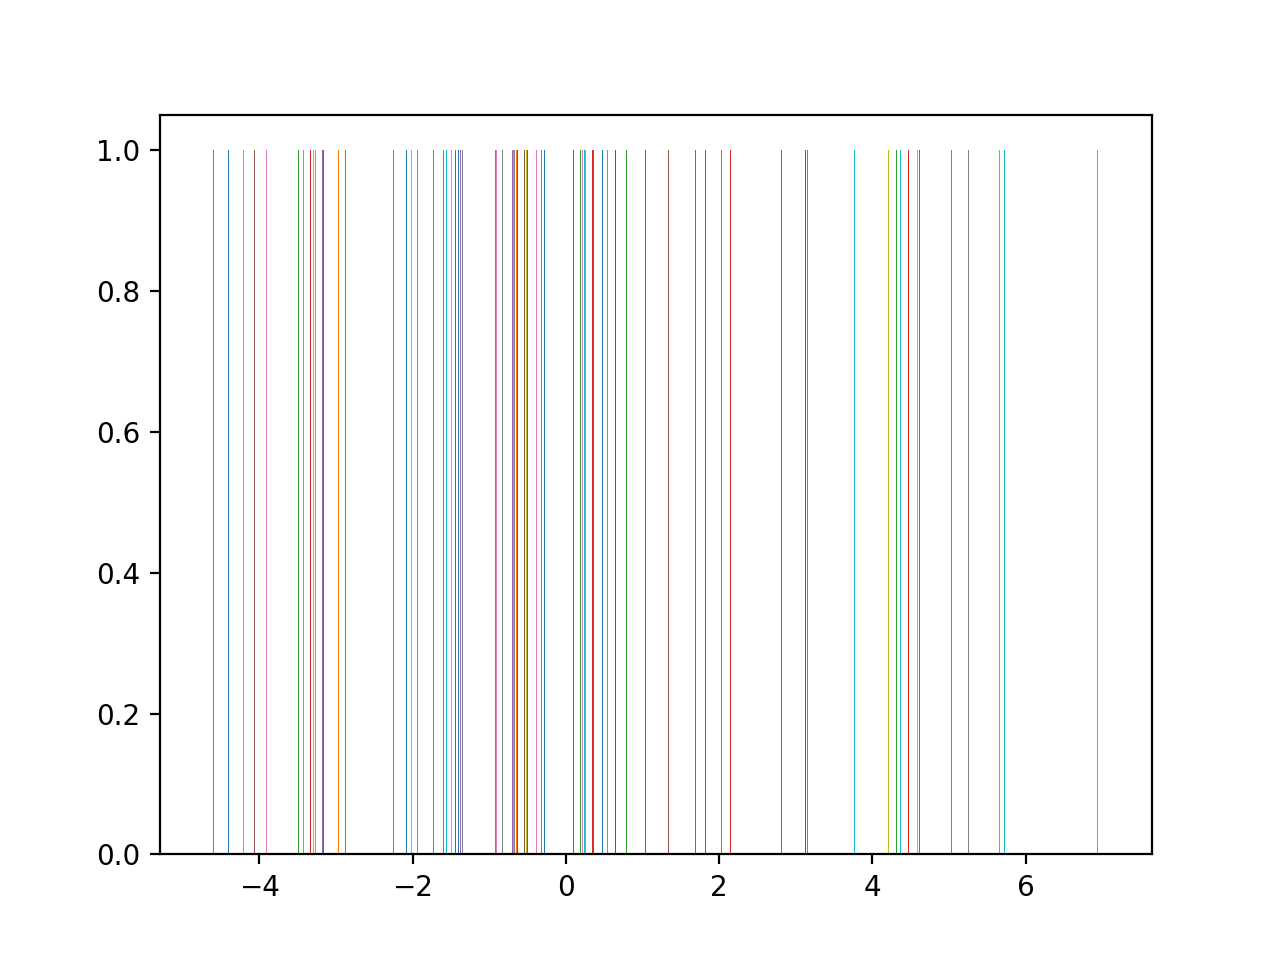

In [59]:
plt.hist(elite_params["RLIF"]["b"]) # input weights hidden layer 1
plt.show()

<IPython.core.display.Javascript object>


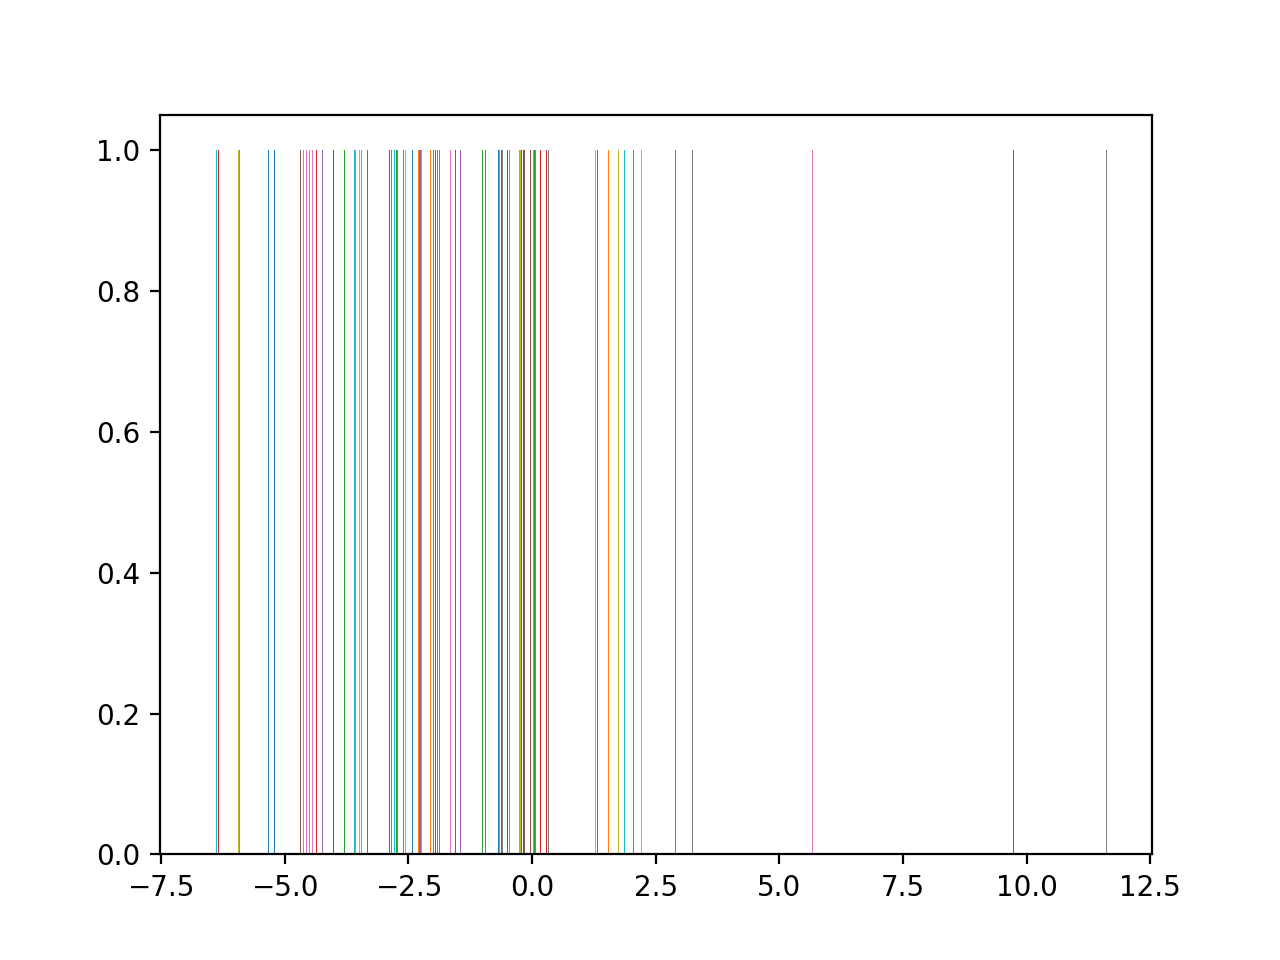

In [60]:
plt.hist(elite_params["RLIF"]["w"]) # input weights hidden layer 1
plt.show()